In [1]:
# Load libraries and the dataset (recent years filter: 2015-2024)
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from matplotlib.ticker import FuncFormatter
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

DATA_FILE = r"/mnt/data/BMW sales data (2010-2024) (1).csv"
df = pd.read_csv(DATA_FILE)
print('Original shape:', df.shape)
# Normalize column names
df.columns = [c.strip().replace('\n',' ').replace(' ','_') for c in df.columns]
df.head()

Original shape: (50000, 11)


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


**Explanation:** This cell loads the necessary libraries and reads the CSV into `df`. Column names are normalized (whitespace and newlines replaced with underscores). The first few rows are displayed so you can confirm the load.

In [2]:
# Quick inspection: dtypes, missing values, and detect key columns
print('Columns:', df.columns.tolist())
print('\nData types:') 
display(df.dtypes)
print('\nMissing values (top):')
display(df.isnull().sum().sort_values(ascending=False).head(20))

# Attempt to detect date, sales, model, country columns
date_col = next((c for c in df.columns if 'date' in c.lower()), None)
year_col = next((c for c in df.columns if c.lower()=='year'), None)
month_col = next((c for c in df.columns if c.lower()=='month'), None)
sales_col = next((c for c in df.columns if any(k in c.lower() for k in ['sales','units','sold','quantity','volume','amount'])), None)
model_col = next((c for c in df.columns if 'model' in c.lower()), None)
country_col = next((c for c in df.columns if any(k in c.lower() for k in ['country','market','region'])), None)

print('\nDetected columns:')
print('date_col =', date_col)
print('year_col =', year_col)
print('month_col =', month_col)
print('sales_col =', sales_col)
print('model_col =', model_col)
print('country_col =', country_col)

# show small sample of suspicious columns
for c in [date_col, year_col, month_col, sales_col, model_col, country_col]:
    if c and c in df.columns:
        print(f'\nSample values for {c}:', df[c].dropna().astype(str).unique()[:10])

Columns: ['Model', 'Year', 'Region', 'Color', 'Fuel_Type', 'Transmission', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume', 'Sales_Classification']

Data types:


Model                    object
Year                      int64
Region                   object
Color                    object
Fuel_Type                object
Transmission             object
Engine_Size_L           float64
Mileage_KM                int64
Price_USD                 int64
Sales_Volume              int64
Sales_Classification     object
dtype: object


Missing values (top):


Model                   0
Year                    0
Region                  0
Color                   0
Fuel_Type               0
Transmission            0
Engine_Size_L           0
Mileage_KM              0
Price_USD               0
Sales_Volume            0
Sales_Classification    0
dtype: int64


Detected columns:
date_col = None
year_col = Year
month_col = None
sales_col = Sales_Volume
model_col = Model
country_col = Region

Sample values for Year: ['2016' '2013' '2022' '2024' '2020' '2017' '2014' '2019' '2012' '2015']

Sample values for Sales_Volume: ['8300' '3428' '6994' '4047' '3080' '1232' '7949' '632' '8944' '4411']



Sample values for Model: ['5 Series' 'i8' 'X3' '7 Series' 'M5' '3 Series' 'X1' 'M3' 'X5' 'i3']

Sample values for Region: ['Asia' 'North America' 'Middle East' 'South America' 'Europe' 'Africa']


**Explanation:** This cell prints column names, data types, and missing value counts. It also attempts to auto-detect likely `date`, `year`, `month`, `sales`, `model`, and `country` columns and shows sample values for each detected column.

In [3]:
# Preprocessing: parse dates and clean sales numeric values.
# Use detected columns where possible, otherwise try fallback heuristics.
_date_col = date_col
if not _date_col:
    # if there's separate Year and Month, we'll combine them later
    _date_col = None

if _date_col:
    df['Date'] = pd.to_datetime(df[_date_col], errors='coerce')
else:
    if year_col:
        if month_col and month_col in df.columns:
            df['Date'] = pd.to_datetime(df[year_col].astype(str) + '-' + df[month_col].astype(str) + '-01', errors='coerce')
        else:
            # just year available
            df['Date'] = pd.to_datetime(df[year_col].astype(str) + '-01-01', errors='coerce')

# Clean sales column to numeric
_sales_col = sales_col
if _sales_col:
    df[_sales_col + '_clean'] = pd.to_numeric(df[_sales_col].astype(str).str.replace(',','').str.replace(' ','').replace('nan', np.nan), errors='coerce')
else:
    # fallback: pick first numeric column that looks like counts
    numc = df.select_dtypes(include=[np.number]).columns.tolist()
    if numc:
        _sales_col = numc[0]
        df[_sales_col + '_clean'] = df[_sales_col].astype(float)
    else:
        raise ValueError('No sales-like or numeric column found; please check your CSV.')

# Use the cleaned sales column
final_sales = _sales_col + '_clean'
print('Using sales column:', final_sales)

# Filter to recent years 2015-2024 inclusive
if 'Date' in df.columns:
    df['Year'] = df['Date'].dt.year
    df_recent = df[(df['Year']>=2015) & (df['Year']<=2024)].copy()
else:
    # if no Date, check Year column
    if year_col:
        df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
        df_recent = df[(df[year_col]>=2015) & (df[year_col]<=2024)].copy()
        df_recent['Year'] = df_recent[year_col]
    else:
        raise ValueError('No Date or Year column found to filter recent years.')

print('Filtered shape (2015-2024):', df_recent.shape)
df_recent[[final_sales,'Year']].head()

Using sales column: Sales_Volume_clean


Filtered shape (2015-2024): (33384, 13)


,Sales_Volume_clean,Year
0,8300,2016
2,6994,2022
3,4047,2024
4,3080,2020
5,1232,2017


**Explanation:** This cell parses a `Date` column when available or constructs one from `Year`/`Month`. It creates a cleaned numeric sales column (suffix `_clean`) and filters the dataset to years 2015–2024, storing the result in `df_recent`.

In [4]:
# Aggregations: total sales by year, top models, top countries, monthly global
grouped = {}
# total by year
if 'Year' in df_recent.columns:
    total_by_year = df_recent.groupby('Year')[final_sales].sum().reset_index().sort_values('Year')
    grouped['total_by_year'] = total_by_year
    total_by_year.to_csv('/mnt/data/total_sales_by_year_recent.csv', index=False)
    display(total_by_year)

# top models
if model_col and model_col in df_recent.columns:
    top_models = df_recent.groupby(model_col)[final_sales].sum().reset_index().sort_values(final_sales, ascending=False)
    grouped['top_models'] = top_models
    top_models.head(15).to_csv('/mnt/data/top_models_by_total_sales_recent.csv', index=False)
    display(top_models.head(15))
else:
    print('No model column detected or available in data.')

# top countries
if country_col and country_col in df_recent.columns:
    top_countries = df_recent.groupby(country_col)[final_sales].sum().reset_index().sort_values(final_sales, ascending=False)
    grouped['top_countries'] = top_countries
    top_countries.head(15).to_csv('/mnt/data/top_countries_by_total_sales_recent.csv', index=False)
    display(top_countries.head(15))
else:
    print('No country/market column detected or available in data.')

# monthly global series
if 'Date' in df_recent.columns:
    monthly_global = df_recent.groupby(pd.Grouper(key='Date', freq='M'))[final_sales].sum().reset_index().sort_values('Date')
    grouped['monthly_global'] = monthly_global
    monthly_global.to_csv('/mnt/data/monthly_global_sales_recent.csv', index=False)
    display(monthly_global.head(10))

,Year,Sales_Volume_clean
0,2015,17010207
1,2016,16957550
2,2017,16620811
3,2018,16412273
4,2019,17191956
5,2020,16310843
6,2021,16884666
7,2022,17920946
8,2023,16268654
9,2024,17527854


,Model,Sales_Volume_clean
2,7 Series,16085636
0,3 Series,15651205
10,i8,15551118
1,5 Series,15512630
8,X6,15320129
4,M5,15298153
9,i3,15297719
5,X1,15204206
7,X5,15117887
6,X3,15077491


,Region,Sales_Volume_clean
2,Europe,28667567
4,North America,28425441
1,Asia,28337556
3,Middle East,28318578
0,Africa,27686790
5,South America,27669828


,Date,Sales_Volume_clean
0,2015-01-31,17010207
1,2015-02-28,0
2,2015-03-31,0
3,2015-04-30,0
4,2015-05-31,0
5,2015-06-30,0
6,2015-07-31,0
7,2015-08-31,0
8,2015-09-30,0
9,2015-10-31,0


**Explanation:** This cell computes and displays key aggregated summaries: total sales by year, top models and top countries (if detected), and monthly global sales. It also saves these summaries as CSV files in `/mnt/data`.

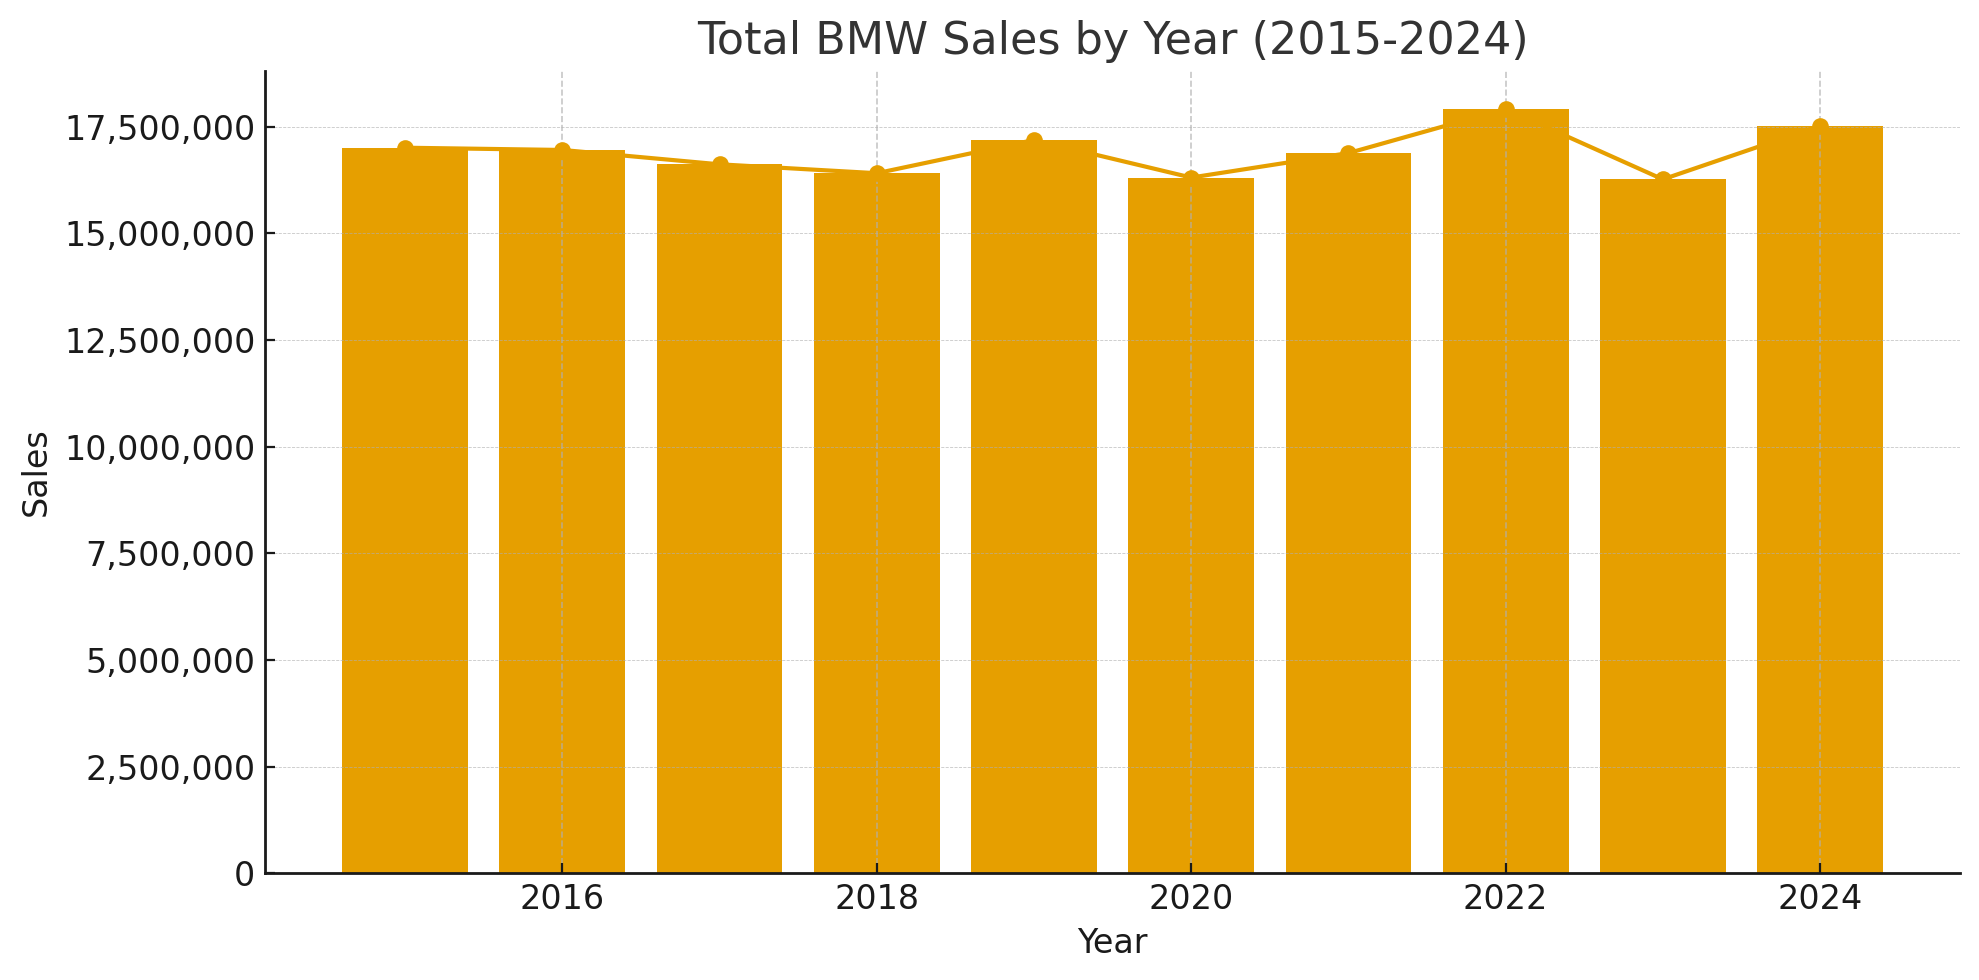

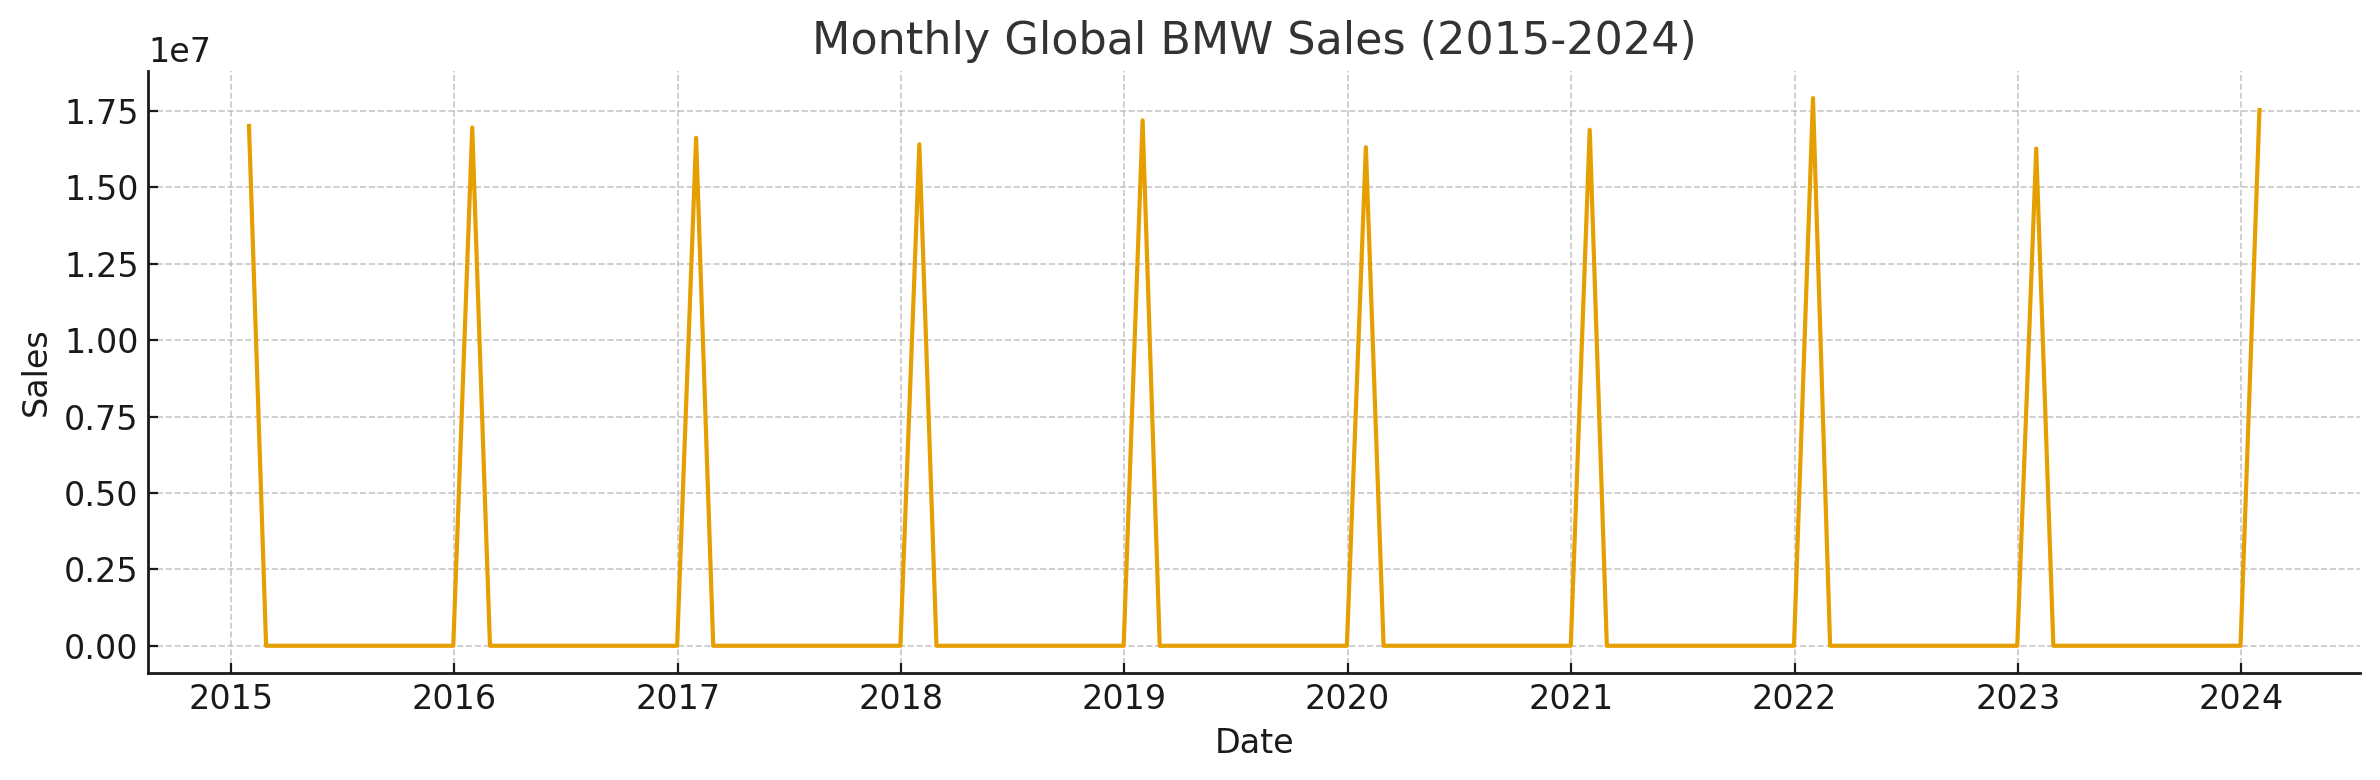

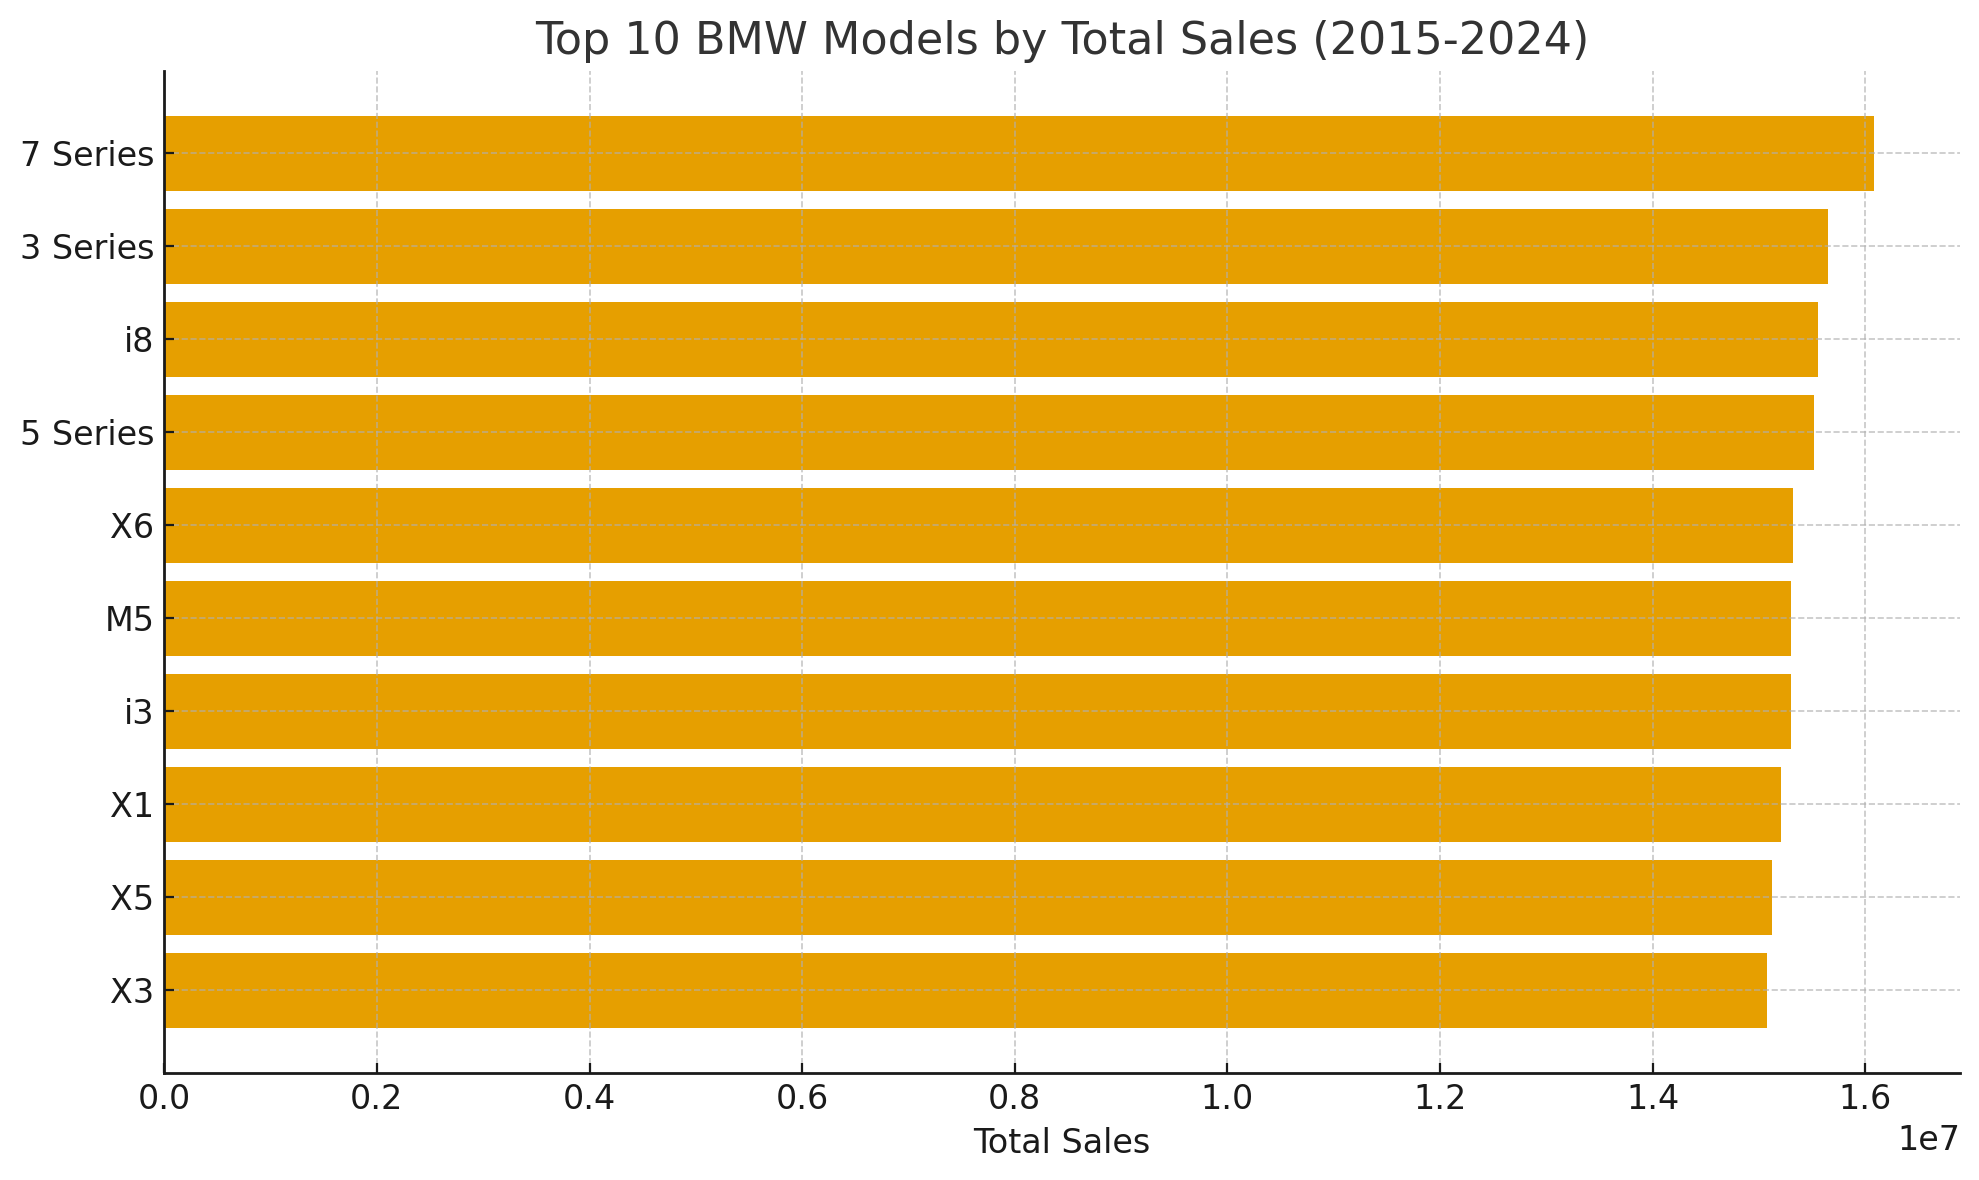

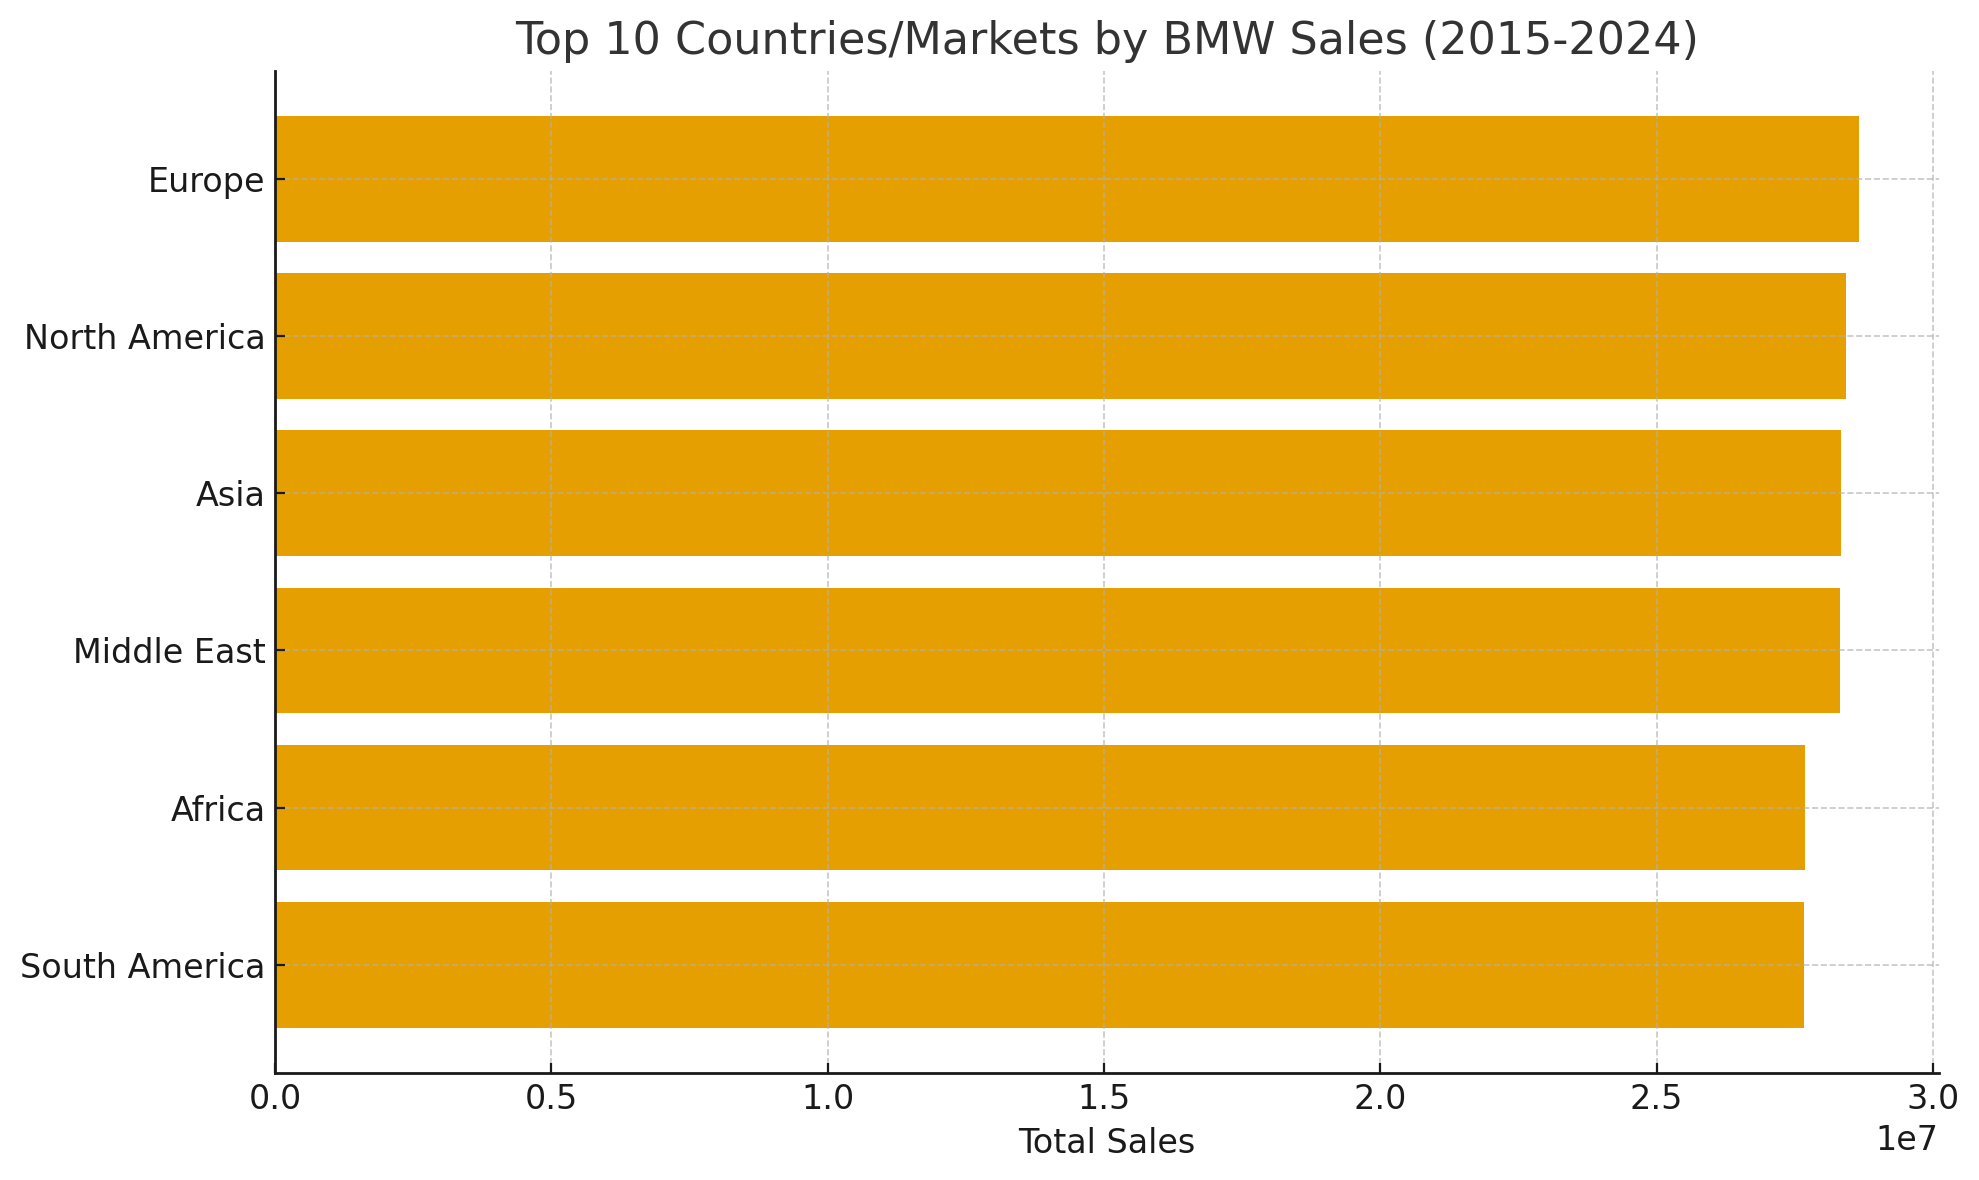

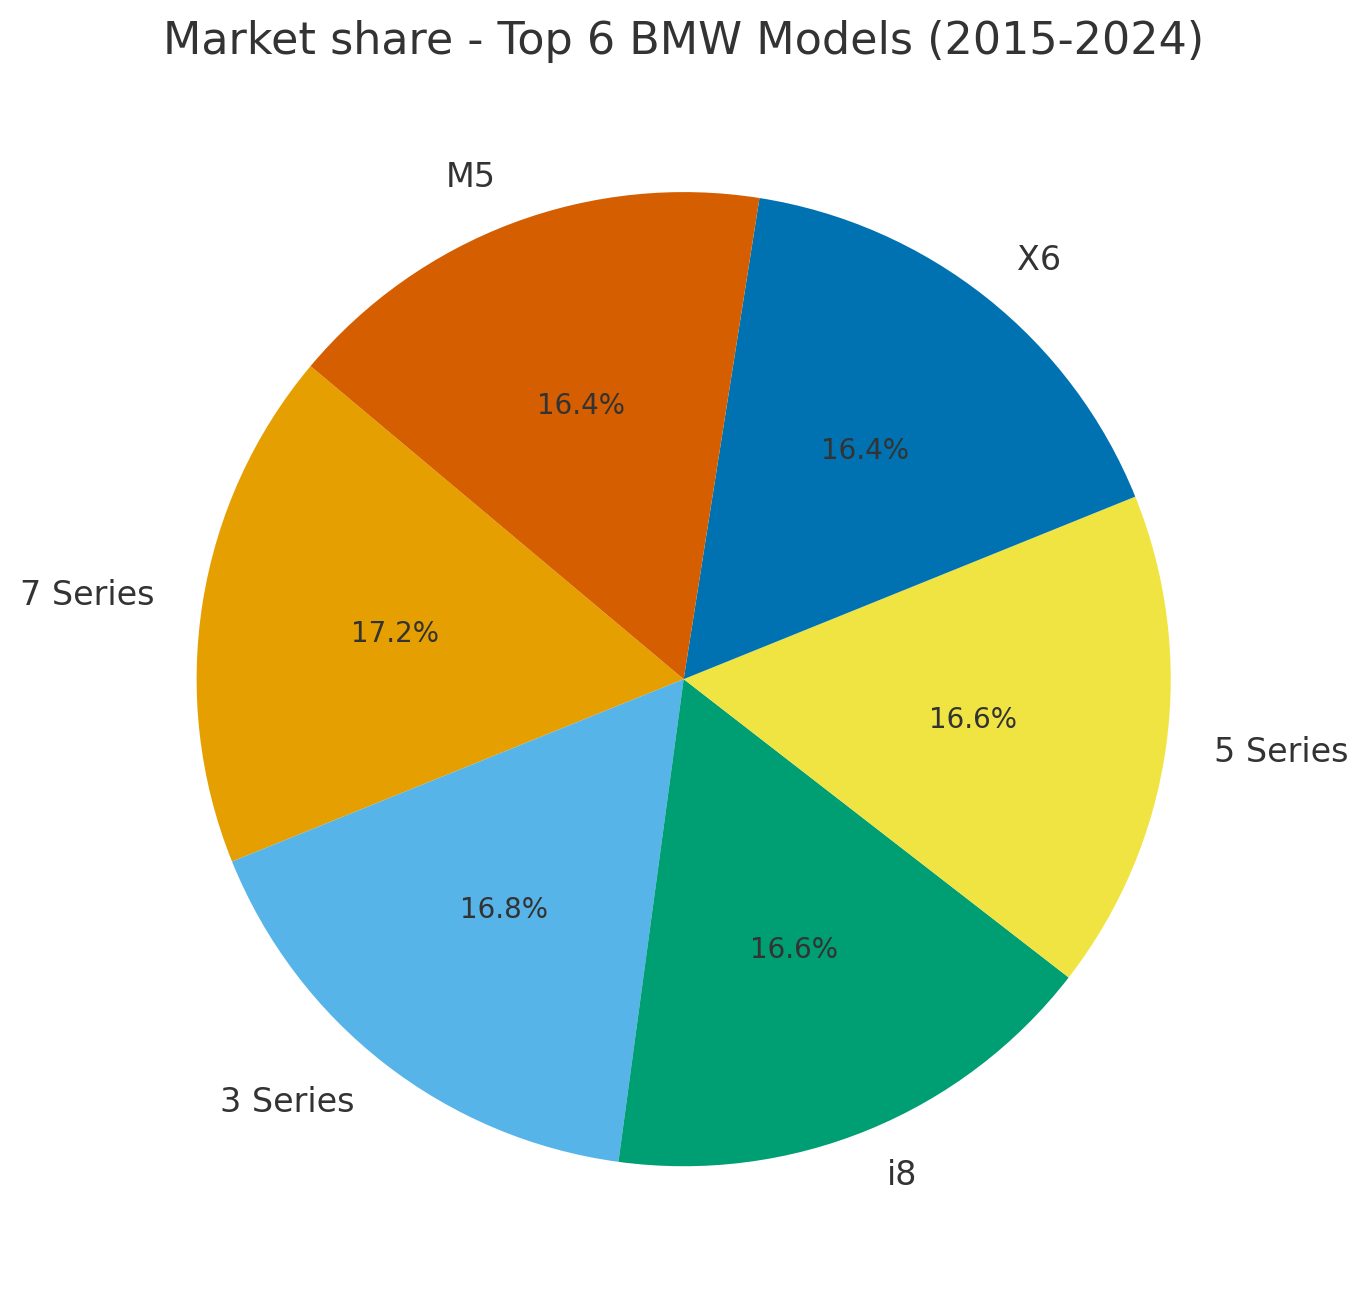

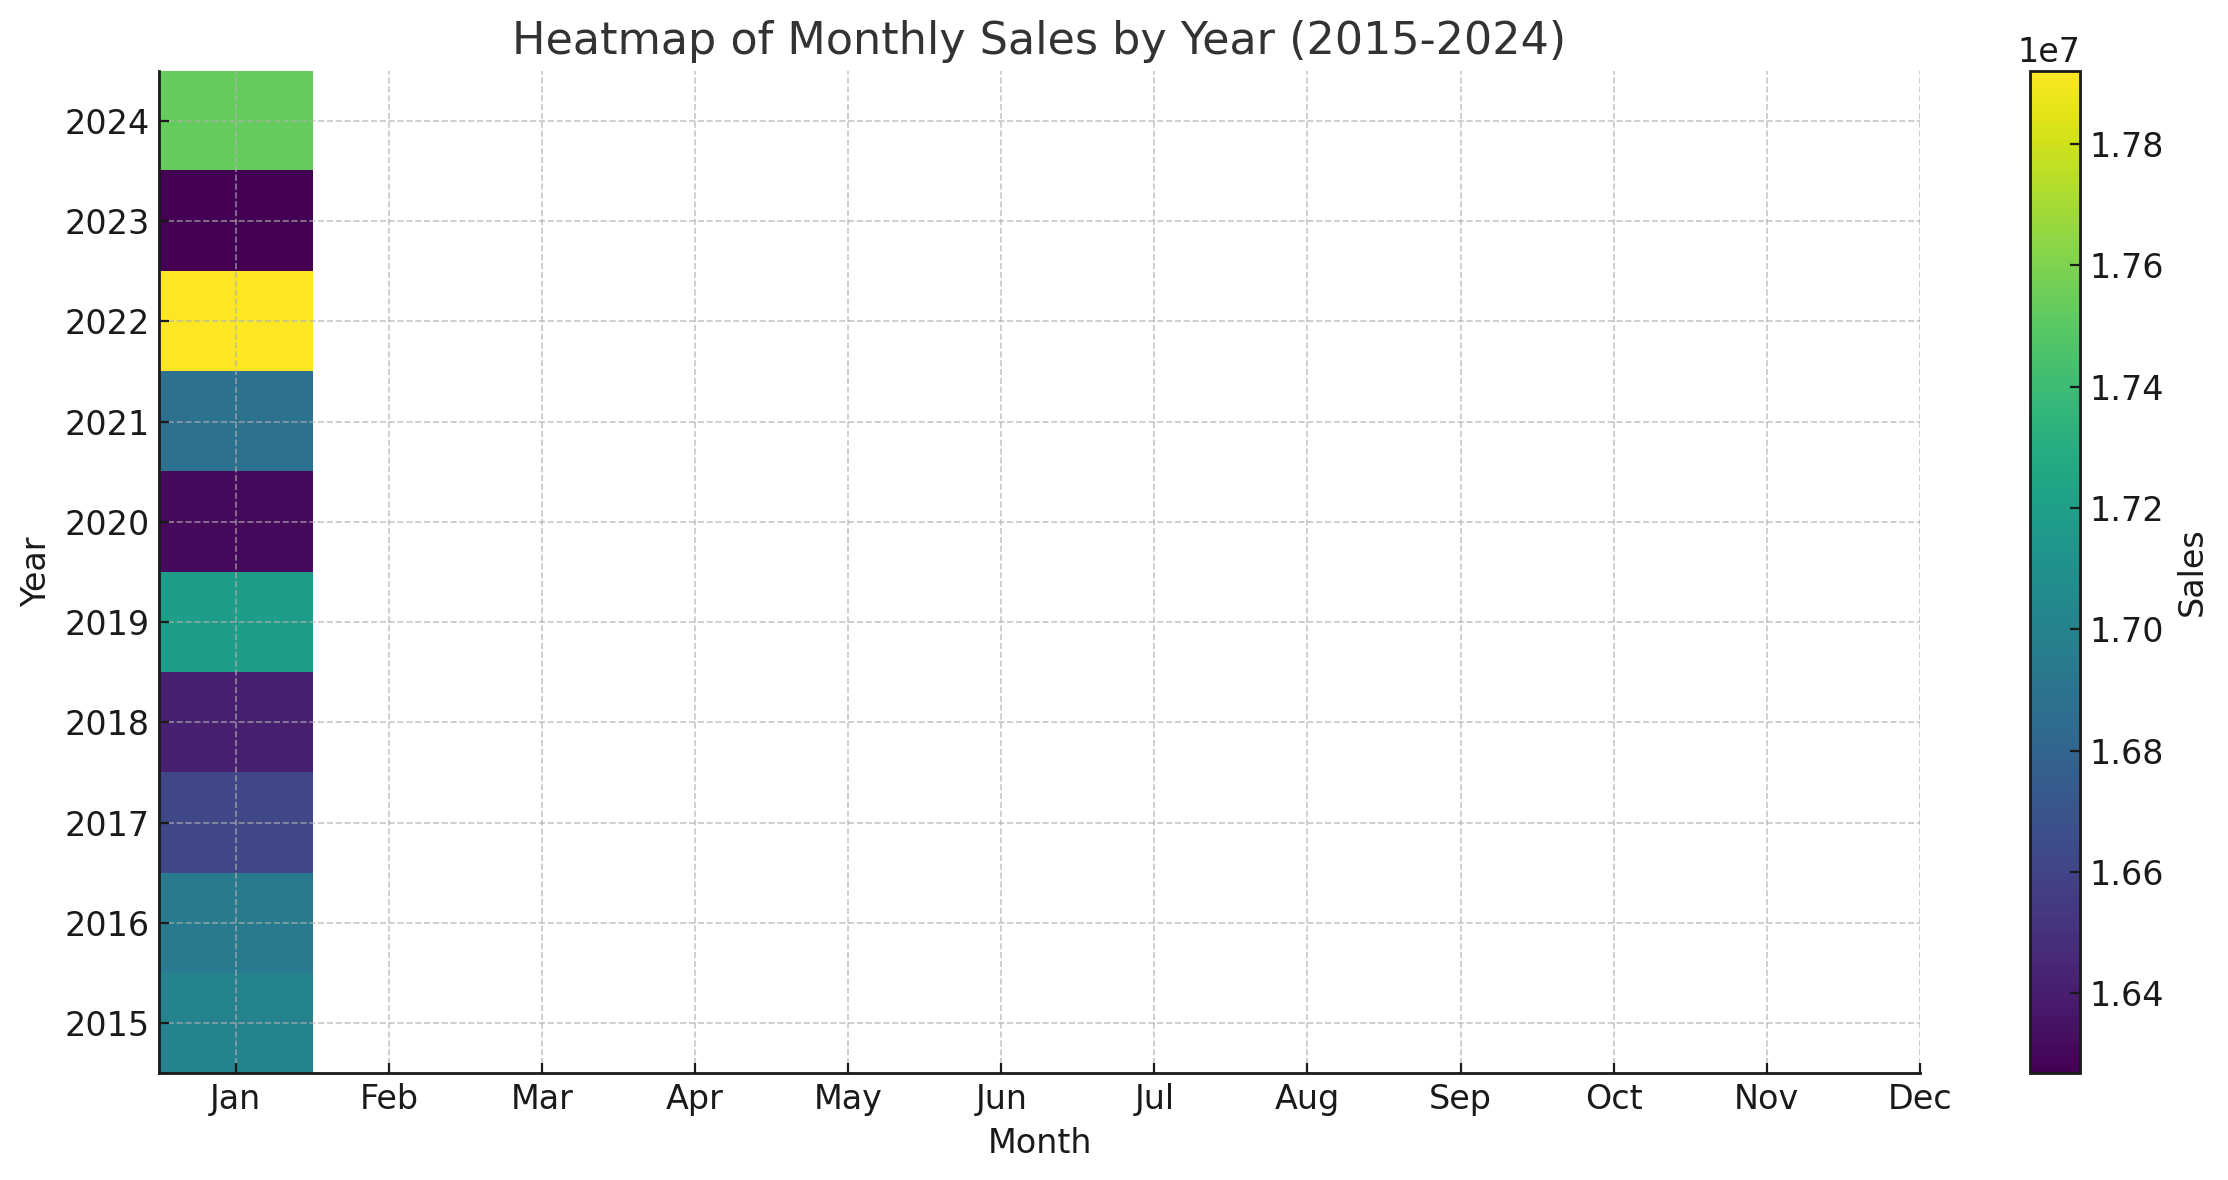

,Year,Sales_Volume_clean,YoY_pct_change
0,2015,17010207,NaN
1,2016,16957550,-0.309561
2,2017,16620811,-1.985776
3,2018,16412273,-1.254680
4,2019,17191956,4.750609
5,2020,16310843,-5.125147
6,2021,16884666,3.518046
7,2022,17920946,6.137403
8,2023,16268654,-9.219893
9,2024,17527854,7.740038


In [5]:
# Visualizations (plots will be captured in notebook outputs)
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
fmt = FuncFormatter(lambda x, p: format(int(x), ','))

# 1) Yearly totals
if 'total_by_year' in locals() or 'total_by_year' in globals() or 'total_by_year' in grouped:
    t = grouped.get('total_by_year') if 'grouped' in globals() else total_by_year
    plt.figure(figsize=(10,5))
    plt.bar(t['Year'], t[final_sales])
    plt.plot(t['Year'], t[final_sales], marker='o')
    plt.title('Total BMW Sales by Year (2015-2024)')
    plt.xlabel('Year'); plt.ylabel('Sales')
    plt.gca().yaxis.set_major_formatter(fmt)
    plt.grid(axis='y', linestyle='--', linewidth=0.3)
    plt.tight_layout(); plt.show()
else:
    print('No yearly totals to plot.')

# 2) Monthly time series
if 'monthly_global' in grouped:
    mg = grouped['monthly_global']
    plt.figure(figsize=(12,4))
    plt.plot(mg['Date'], mg[final_sales])
    plt.title('Monthly Global BMW Sales (2015-2024)')
    plt.xlabel('Date'); plt.ylabel('Sales')
    plt.tight_layout(); plt.show()
else:
    print('No monthly series available.')

# 3) Top 10 models
if 'top_models' in grouped:
    top10 = grouped['top_models'].head(10).iloc[::-1]
    plt.figure(figsize=(10,6))
    plt.barh(top10[top10.columns[0]], top10[final_sales])
    plt.title('Top 10 BMW Models by Total Sales (2015-2024)')
    plt.xlabel('Total Sales'); plt.tight_layout(); plt.show()
else:
    print('Top models not available to plot.')

# 4) Top 10 countries
if 'top_countries' in grouped:
    ctop = grouped['top_countries'].head(10).iloc[::-1]
    plt.figure(figsize=(10,6))
    plt.barh(ctop[ctop.columns[0]], ctop[final_sales])
    plt.title('Top 10 Countries/Markets by BMW Sales (2015-2024)')
    plt.xlabel('Total Sales'); plt.tight_layout(); plt.show()
else:
    print('Top countries not available to plot.')

# 5) Pie - top 6 models market share
if 'top_models' in grouped:
    pie = grouped['top_models'].head(6)
    plt.figure(figsize=(7,7))
    plt.pie(pie[final_sales], labels=pie[pie.columns[0]], autopct='%1.1f%%', startangle=140)
    plt.title('Market share - Top 6 BMW Models (2015-2024)'); plt.tight_layout(); plt.show()

# 6) Heatmap month vs year
if 'Date' in df_recent.columns:
    heat = df_recent.copy()
    heat['Month'] = heat['Date'].dt.month
    heat['Year'] = heat['Date'].dt.year
    pivot = heat.groupby(['Year','Month'])[final_sales].sum().unstack(fill_value=0)
    plt.figure(figsize=(12,6))
    plt.imshow(pivot, aspect='auto', origin='lower')
    plt.colorbar(label='Sales')
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(12), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.title('Heatmap of Monthly Sales by Year (2015-2024)'); plt.xlabel('Month'); plt.ylabel('Year')
    plt.tight_layout(); plt.show()
else:
    print('No Date column for heatmap.')

# 7) Year-over-year % change
if 'total_by_year' in grouped:
    yoy = grouped['total_by_year'].copy()
    yoy['YoY_pct_change'] = yoy[final_sales].pct_change() * 100
    display(yoy)
else:
    print('No YoY available')

**Explanation:** This cell produces visualizations captured in the notebook outputs: yearly totals (bar + line), monthly time series, top-10 models and countries (horizontal bars), market-share pie for top models, a heatmap of monthly sales by year, and a table of year-over-year percent change.

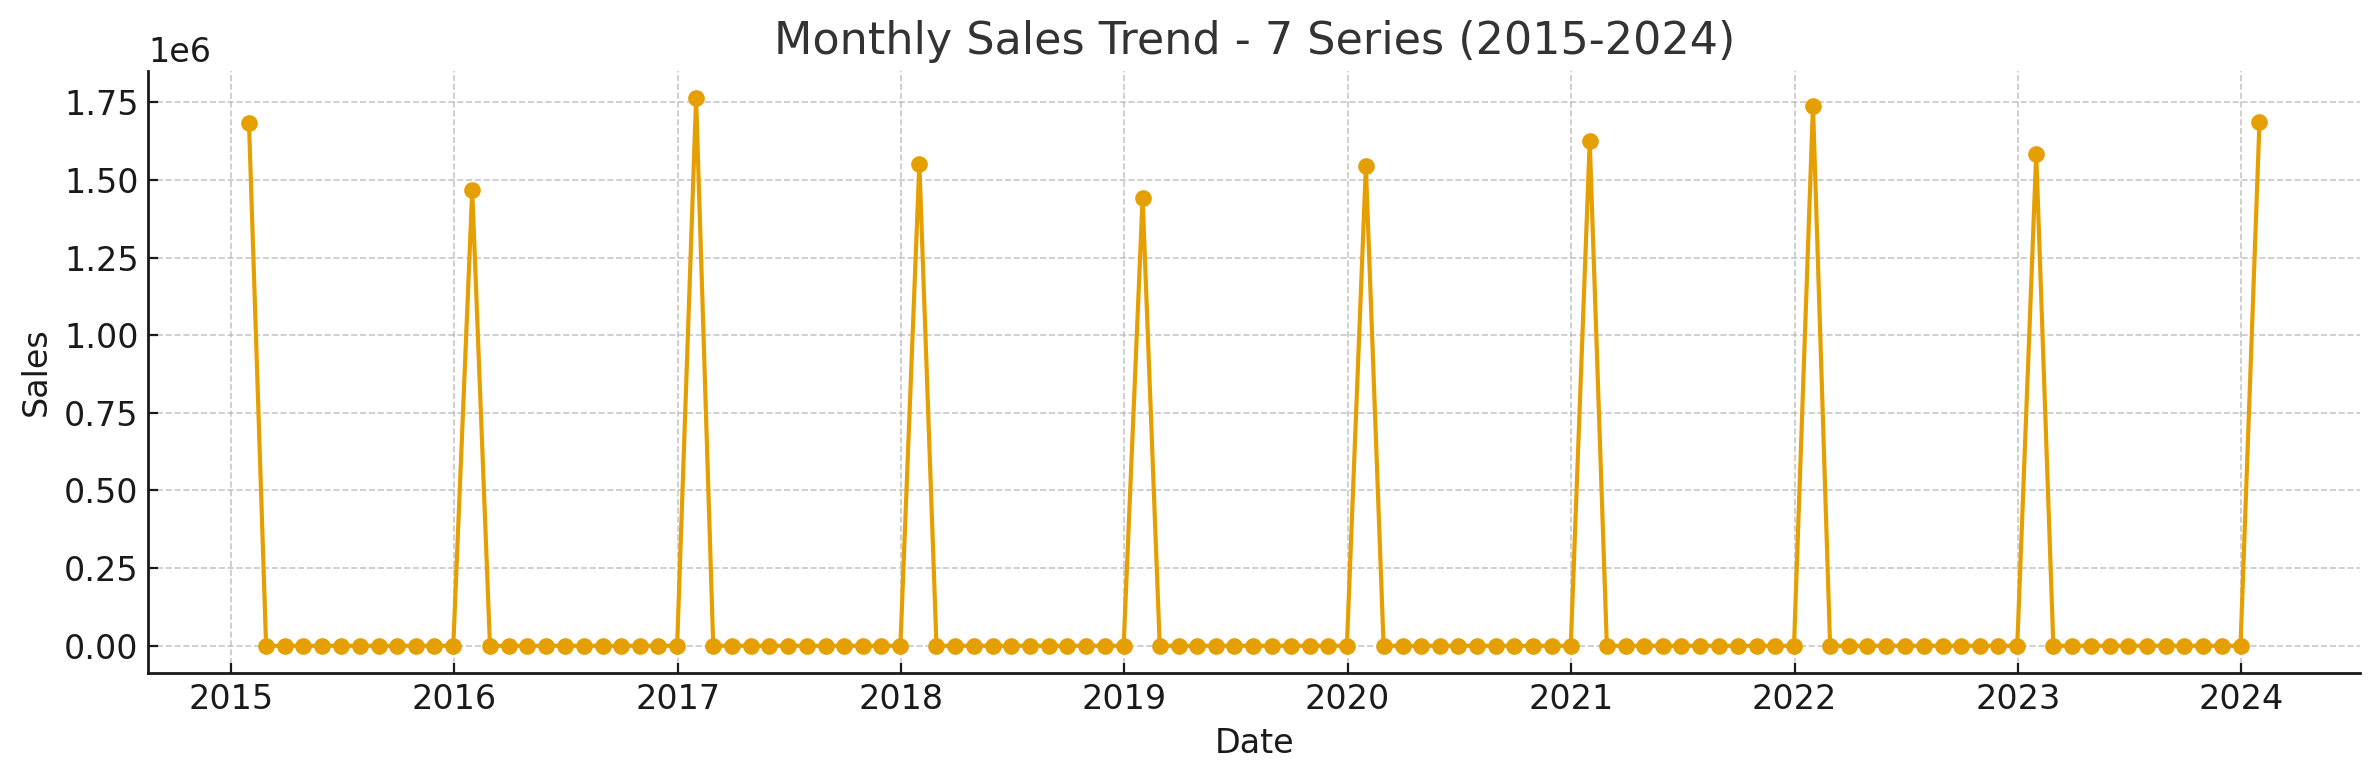

Saved /mnt/data/top_model_trend.png


<Figure size 2000x1200 with 0 Axes>

In [6]:
# Additional: monthly trend for the single top model (if model column exists)
if 'top_models' in grouped and model_col in df_recent.columns:
    top_model_name = grouped['top_models'].iloc[0][model_col]
    ts = df_recent[df_recent[model_col]==top_model_name].groupby(pd.Grouper(key='Date', freq='M'))[final_sales].sum().reset_index()
    plt.figure(figsize=(12,4))
    plt.plot(ts['Date'], ts[final_sales], marker='o')
    plt.title(f'Monthly Sales Trend - {top_model_name} (2015-2024)'); plt.xlabel('Date'); plt.ylabel('Sales')
    plt.tight_layout(); plt.show()
    # save a PNG for GitHub if desired
    plt.savefig('/mnt/data/top_model_trend.png')
    print('Saved /mnt/data/top_model_trend.png')
else:
    print('No model-level trend available')

**Explanation:** If the dataset includes a model column, this cell plots the monthly sales trend for the top-selling model and saves a PNG of the chart to `/mnt/data`.